#### Environment set

In [1]:
# %load_ext nb_black
from IPython.core.debugger import set_trace

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

plt.style.use(style="seaborn")
%matplotlib inline

#### Data preparation

Synthetic Financial Datasets For Fraud Detection

It simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. 

Src: https://www.kaggle.com/datasets/ealaxi/paysim1

In [4]:
df = pd.read_csv(
    f"PS_20174392719_1491204439457_log.csv", 
    encoding="ISO-8859-1", 
    error_bad_lines=False
)
df.shape

(6362620, 11)

In [5]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

#### Descriptive analysis

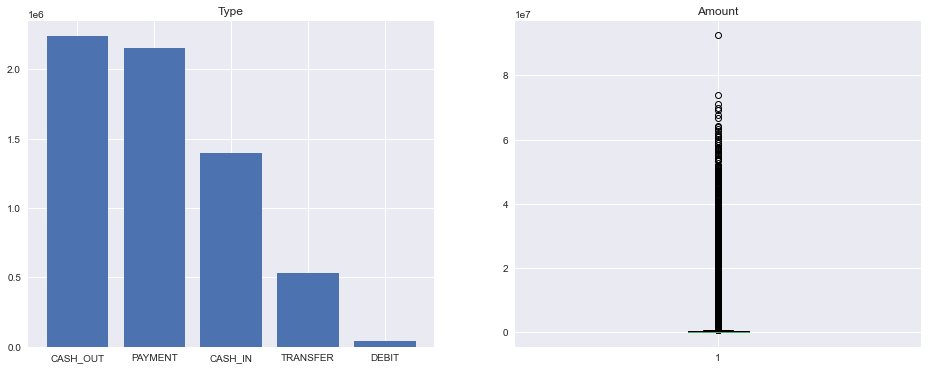

In [24]:
# type bar plot
x = df["type"].value_counts().index
y = df["type"].value_counts().values

f = plt.figure(1, figsize=(16, 6))
ax1 = f.add_subplot(1, 2, 1)
ax1.title.set_text("Type")
_ = ax1.bar(x, y)

# amount bar plot
z = df["amount"]

ax2 = f.add_subplot(1, 2, 2)
ax2.title.set_text("Amount")
_ = ax2.boxplot(z)

Boxplot reference
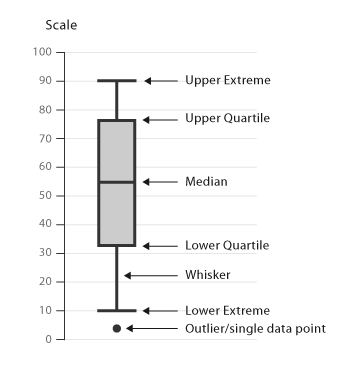

## IForest

Isolation Forest is one of the most efficient algorithms for outlier detection especially in high dimensional datasets.

The model builds a Random Forest in which each Decision Tree is grown randomly. 

At each node it picks a feature randomly and then a random threshold value (between min and max) to split the dataset in two. 

As the dataset gets gradually chopped into pieces, each observation gets isolated from the others. 

Anomalies are far from the others therefore they get to be isolated in less steps than normal observations.

![](https://miro.medium.com/max/3268/1*TqkqI2QECywBLnY6KlVvHA.png)

#### Preprocessing

In [26]:
data = df.copy()

# drop label
data.drop(columns=['step',"isFraud","isFlaggedFraud"], inplace=True)

# transform illegal type of columns to the acceptable format by the algorithm
for col in data.columns:
    if data[col].dtype == "object":
        le = LabelEncoder()
        data[col].fillna("None", inplace=True)
        le.fit(list(data[col].astype(str).values))
        data[col] = le.transform(list(data[col].astype(str).values))
    else:
        data[col].fillna(-999, inplace=True)

In [27]:
data.head(5)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,iforest
0,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0
1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0
2,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,0
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,0
4,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0


#### training

In [28]:
from sklearn.ensemble import IsolationForest

# Estimation of anomaly population of the dataset (necessary for IForest)
contamination = 0.01

data = df.copy()
%%time
model = IsolationForest(contamination=contamination, n_estimators=100)
model.fit(data)

Wall time: 2min 54s


IsolationForest(contamination=0.01)

#### predicting

In [29]:
df["iforest"] = pd.Series(model.predict(data))
df["iforest"] = df["iforest"].map({1: 0, -1: 1})
print(df["iforest"].value_counts())

0    6298993
1      63627
Name: iforest, dtype: int64


In [14]:
df.head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,iforest
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,0
